In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Reshape, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# **Read Data**

In [3]:
data = pd.read_csv('data.txt')

In [4]:
data.head()

,1
0,ای رستخیز ناگهان، وی رحمت بی منتها\tای آتشی اف...
1,امروز خندان آمدی، مفتاح زندان آمدی\tبر مستمندا...
2,خورشید را حاجب تویی، امید را واجب تویی\tمطلب ت...
3,در سینه ها برخاسته، اندیشه را آراسته\tهم خویش ...
4,ای روح بخش بی بَدَل، وی لذتِ علم و عمل\tباقی ب...


**Read Stop-Words**

In [5]:
def read_stop_words(filename):
  with open(filename) as stopwords_file:
    stopwords = stopwords_file.readlines()
  stopwords = [line.replace('\n', '') for line in stopwords] 
  return stopwords

In [6]:
stopwords = read_stop_words('stopwords.txt')
print(len(stopwords))

1382


**hazm library**

In [7]:
# install hazm library
!pip install hazm
from hazm import word_tokenize

     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 1.4 MB 49.0 MB/s 
     |████████████████████████████████| 233 kB 49.0 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=b54a78e3b60651e6622b2db21afb50b7b5a166a9c141e2f0470aa357733bd3a1
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154031 sha256=a52667381b42613306921543c24025518ef12719367c586dde8dda94b31fe6d8
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


### **Preprocess the text**

In [8]:
# preprocess the text
def text_preprocess(data):
  text = [line.replace('\t', ' ') for line in data.values.flatten()]
  text = [line.replace('-', ' ') for line in text]
  text = [re.sub("\d+", "", t) for t in text]

  word_tokenized = [word_tokenize(t) for t in text]
  word_tokenized_filtered = [[w for w in sentence if w not in stopwords] for sentence in word_tokenized]

  sentences = [' '.join(sentence) for sentence in word_tokenized_filtered]
  sentences = [sentence for sentence in sentences if sentence != '']

  return sentences


In [9]:
sentences = text_preprocess(data)

In [10]:
sentences[0]

'رستخیز رحمت منتها آتشی افروخته بیشه اندیشه'

### **get less frequente words**

In [11]:
def get_all_sentences():
  all_sentences = ''
  sentences = text_preprocess(data)
  for sentence in sentences:
    all_sentences += sentence
    all_sentences += ' '

  return all_sentences  

In [12]:
def get_word_freq(vocabularies):
  word_freq = []
  for vocab in vocabularies:
    word_freq.append(vocabularies.count(vocab))
  return word_freq  

In [13]:
# get the words that frequentes less than 2 times in the corpus
def get_less_frequente_words():
  low_frequency_words = []
  all_sentences = get_all_sentences()
  vocabularies = all_sentences.split(' ')
  word_freq = get_word_freq(vocabularies)

  for i in range(len(word_freq)):
    if word_freq[i] < 2:
      low_frequency_words.append(vocabularies[i])

  return low_frequency_words

In [14]:
less_frequente_words = get_less_frequente_words()

In [15]:
print(len(less_frequente_words))

6366


## **remove less frequente words**

In [16]:
# remove the words that frequentes less than 2 times in the corpus
def remove_less_frequente_words(less_frequente_words, sentences):
  sentences_tokenized = [word_tokenize(sentence) for sentence in sentences]
  sentences_tokenized_filtered = [[w for w in sentence if w not in less_frequente_words] for sentence in sentences_tokenized]
  corpus = [' '.join(sentence) for sentence in sentences_tokenized_filtered]
  corpus = [sentence for sentence in corpus if sentence != '']

  return corpus

In [17]:
corpus = remove_less_frequente_words(less_frequente_words, sentences)

In [18]:
corpus[0:10]

['رستخیز رحمت منتها آتشی افروخته بیشه اندیشه',
 'خندان آمدی مفتاح زندان آمدی آمدی بخشش فضل خدا',
 'خورشید حاجب تویی امید واجب تویی مطلب تویی طالب تویی منتها',
 'سینه اندیشه آراسته حاجت روا',
 'روح علم باقی بهانه دغل علت دوا',
 'دغل کژ گنه کین مست مست نان شوربا',
 'هل عقل هل نان نشاید ماجرا',
 'تدبیر رنگ افکنی روم زنگ افکنی جنگ افکنی یری',
 'پنهان گوش جان بهانه کسان جان رب زنان والله کیا',
 'خامش رفتم پای علم کاغذ بنه بشکن قلم ساقی درآمد الصلا']

## **Tokenizer**

In [19]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [20]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [21]:
print(tokenizer.word_index)

{'جان': 1, 'دل': 2, 'عشق': 3, 'آب': 4, 'چشم': 5, 'شب': 6, 'جهان': 7, 'شمس': 8, 'دست': 9, 'مست': 10, 'گل': 11, 'یار': 12, 'عقل': 13, 'جمله': 14, 'غم': 15, 'آتش': 16, 'نور': 17, 'مه': 18, 'خاک': 19, 'تن': 20, 'عالم': 21, 'تبریز': 22, 'خدا': 23, 'شاه': 24, 'ره': 25, 'خانه': 26, 'باده': 27, 'عاشق': 28, 'تویی': 29, 'روح': 30, 'ساقی': 31, 'خون': 32, 'ماه': 33, 'کف': 34, 'رخ': 35, 'لطف': 36, 'شکر': 37, 'پا': 38, 'زر': 39, 'آسمان': 40, 'گوش': 41, 'عاشقان': 42, 'زمین': 43, 'بحر': 44, 'ذره': 45, 'خورشید': 46, 'سخن': 47, 'چرخ': 48, 'گرد': 49, 'پرده': 50, 'باغ': 51, 'جام': 52, 'تبریزی': 53, 'دین': 54, 'آرزوست': 55, 'پای': 56, 'خواب': 57, 'ای': 58, 'آفتاب': 59, 'گشت': 60, 'سو': 61, 'یوسف': 62, 'درد': 63, 'گشته': 64, 'دوست': 65, 'بنده': 66, 'دریا': 67, 'نفس': 68, 'شمع': 69, 'روان': 70, 'شراب': 71, 'دلم': 72, 'هوا': 73, 'برو': 74, 'زبان': 75, 'ببین': 76, 'پنهان': 77, 'سنگ': 78, 'دهان': 79, 'وقت': 80, 'وفا': 81, 'بوی': 82, 'رسد': 83, 'سجده': 84, 'خواجه': 85, 'خمش': 86, 'سایه': 87, 'خار': 88, 'نقش': 89

In [22]:
 # find more stopwords by sorting the tokenizer word counts
#  word_count_sorted = dict(sorted(tokenizer.word_counts.items(), reverse=False, key=lambda t: t[1]))
#  word_count_sorted

In [23]:
encoded = tokenizer.texts_to_sequences(corpus)

In [49]:
encoded[0:10]

[[2726, 283, 1337, 397, 1610, 967, 143],
 [185, 568, 1124, 398, 568, 568, 830, 332, 23],
 [46, 2727, 29, 636, 2031, 29, 831, 29, 258, 29, 1337],
 [92, 143, 1338, 727, 728],
 [30, 221, 162, 399, 1611, 968, 244],
 [1611, 729, 2032, 569, 10, 10, 209, 2728],
 [464, 13, 464, 209, 1125, 419],
 [969, 104, 1612, 352, 1126, 1612, 192, 1612, 730],
 [77, 41, 1, 399, 1613, 1, 259, 245, 284, 1127],
 [201, 731, 56, 221, 2729, 377, 732, 1128, 31, 570, 186]]

In [25]:
num_all_words = sum(len(s) for s in encoded) # total number of words in the corpus
num_unique_words = len(tokenizer.word_index) + 1  # total number of unique words in the corpus

In [26]:
num_all_words, num_unique_words

(32654, 4284)

### **Generate data**

In [27]:
# Parameters
window_size = 2

In [28]:
def generate_data(corpus, window_size, num_unique_words):
    maxlen = window_size * 2
    all_inputs = []
    all_outputs = []
    for words in corpus:
      len_words = len(words)
      for index,w in enumerate(words):
        s = index - window_size
        e = index + window_size + 1
        for i in range(s, e):
            if i != index and 0 <= i < len_words:
              #all_inputs.append(w) 
              all_inputs.append(to_categorical(w, num_unique_words)) 
              all_outputs.append(to_categorical(words[i], num_unique_words))

    return (np.array(all_inputs), np.array(all_outputs))

In [29]:
# Create training data
X_train, y_train = generate_data(encoded, window_size, num_unique_words)
X_train.shape, y_train.shape

((98832, 4284), (98832, 4284))

In [30]:
X_train, y_train

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [31]:
# for i in X_train:
#   print(np.where(i == 1))
print(np.where(X_train[0] == 1))

(array([2726]),)


## **Create Neural Network**

In [32]:
input1 = Input(shape=(X_train.shape[1],))
dense1 = Dense(units=100, activation='linear')(input1)
output1 = Dense(units=y_train.shape[1], activation='softmax')(dense1)
model = Model(inputs=input1, outputs=output1)

# model = Sequential()
# model.add(Input(shape=(X_train.shape[1],)))
# model.add(Dense(units=50, activation='linear'))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units=y_train.shape[1], activation='softmax'))

In [33]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4284)]            0         
                                                                 
 dense (Dense)               (None, 100)               428500    
                                                                 
 dense_1 (Dense)             (None, 4284)              432684    
                                                                 
Total params: 861,184
Trainable params: 861,184
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train, epochs=500, verbose=1, batch_size=512, validation_split=0.2)

Epoch 1/500
155/155 [==============================] - 25s 150ms/step - loss: 7.9545 - accuracy: 0.0240 - val_loss: 7.7563 - val_accuracy: 0.0179
Epoch 2/500
155/155 [==============================] - 15s 96ms/step - loss: 7.4940 - accuracy: 0.0256 - val_loss: 7.8021 - val_accuracy: 0.0179
Epoch 3/500
155/155 [==============================] - 15s 96ms/step - loss: 7.4682 - accuracy: 0.0256 - val_loss: 7.8285 - val_accuracy: 0.0179
Epoch 4/500
155/155 [==============================] - 15s 96ms/step - loss: 7.4473 - accuracy: 0.0256 - val_loss: 7.8499 - val_accuracy: 0.0179
Epoch 5/500
155/155 [==============================] - 15s 97ms/step - loss: 7.4203 - accuracy: 0.0260 - val_loss: 7.8604 - val_accuracy: 0.0192
Epoch 6/500
155/155 [==============================] - 15s 97ms/step - loss: 7.3813 - accuracy: 0.0285 - val_loss: 7.8703 - val_accuracy: 0.0202
Epoch 7/500
155/155 [==============================] - 15s 97ms/step - loss: 7.3292 - accuracy: 0.0301 - val_loss: 7.8741 - val_a

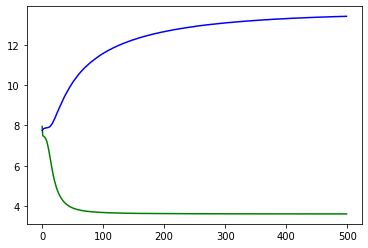

In [36]:
plt.plot(history.history['loss'], color='green', label='Train Data')
plt.plot(history.history['val_loss'], color='blue', label='Validation Data')

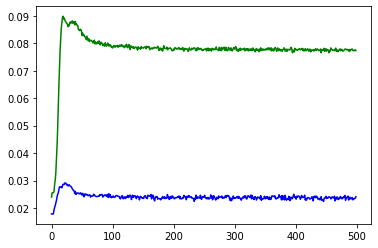

In [37]:
plt.plot(history.history['accuracy'], color='green', label='Train Data')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Data')

In [38]:
model.save('word2vec.h5')

## **Load Model**

In [39]:
# laod model
model = load_model('word2vec.h5')

In [40]:
model

In [41]:
weights = model.get_weights()

In [42]:
weights[0][1]

array([-0.3678592 , -0.35041156, -0.5472734 , -0.707333  , -0.8379311 ,
        0.21526782,  0.5348847 , -0.37712884, -0.1790406 , -0.06838758,
       -0.7753943 ,  0.00430979,  0.8226259 , -0.3004043 , -0.15486704,
        0.4198015 ,  0.78254235,  0.71474075, -0.49433383,  0.45515683,
        0.11145765,  0.6082657 ,  0.17053723,  0.82410467, -0.04604195,
        0.59913605,  0.30833507,  0.04826039, -0.185569  , -0.9114347 ,
       -0.683399  , -0.60392755, -0.01325986,  0.34528697,  0.18896767,
        0.3710613 , -0.12635884,  0.086489  ,  0.18441024, -0.7493928 ,
        0.73838097,  0.48428702, -0.51301557, -0.5504357 ,  0.5049649 ,
        0.25433883,  0.8603807 , -0.26184046,  0.4026695 , -0.08935367,
       -0.35658374,  1.048677  , -0.12000211, -0.58423996, -1.0096934 ,
        0.6490526 , -0.18603194, -0.5482508 ,  0.44427115, -0.12540224,
        0.39631197,  0.2287674 , -0.10721198, -0.3848411 , -0.4588026 ,
       -0.919718  , -0.20322919, -0.3585306 ,  0.22199608,  0.47

In [43]:
with open('tokenizer.h5', 'rb') as f:
    tokenizer = pickle.load(f)

In [44]:
def get_most_similarity(word, model=model, tokenizer=tokenizer, n=15):
  num_unique_words = len(tokenizer.word_index) + 1
  word_to_sequences = tokenizer.texts_to_sequences([word])[0]
  word_to_sequences_one_hot = to_categorical(word_to_sequences, num_unique_words)
  prediction = model.predict(word_to_sequences_one_hot)[0]
  index = np.argsort(prediction)[::-1][:n]
  sequences_to_word = tokenizer.sequences_to_texts([index])[0]
  most_similarity = sequences_to_word.split(' ')
  return most_similarity

In [45]:
get_most_similarity('عشق')

['عشق',
 'جان',
 'دل',
 'عقل',
 'آتش',
 'عاشقان',
 'جمله',
 'شمس',
 'جهان',
 'گشت',
 'ملک',
 'دست',
 'گشته',
 'مست',
 'شاه']

In [46]:
get_most_similarity('جان')

['جان',
 'دل',
 'تن',
 'عشق',
 'جهان',
 'فزا',
 'آب',
 'ساقی',
 'گرد',
 'دست',
 'هزاران',
 'ذره',
 'چشم',
 'عاشقان',
 'جمله']

In [47]:
get_most_similarity('کنج')

['عاشق',
 'زندان',
 'ای',
 'درآرد',
 'نرسم',
 'نشین',
 'کنجی',
 'خلا',
 'کنج',
 'آشفته',
 'شاهی',
 'طلب',
 'قدیمست',
 'نماند',
 'جمله']